In [74]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
from scipy import stats
%matplotlib inline
plt.style.use('fivethirtyeight')

In [2]:
rating_conv = json.load(open('../data_coll/rating_conv.json'))
rev_rating_conv = json.load(open('../data_coll/rev_rating_conv.json'))
routes = pd.read_csv('../data/routes.csv')
users = pd.read_csv('../data/user_ticks.csv', delimiter='|')
climbs = users.merge(routes, how='left', left_on='route_id', right_on='route_id')

In [75]:
sport_max = (climbs[(climbs['style'] == 'Lead')
                    & (climbs['type'] == 'Sport')
                    & (climbs['lead_style'] != 'Fell/Hung')][['user_id','num_rating']]
                .groupby('user_id').aggregate(max).rename(columns={'num_rating': 'sport_max'}))
trad_max = (climbs[(climbs['style'] == 'Lead')
                   & (climbs['type'] == 'Trad')
                   & (climbs['lead_style'] != 'Fell/Hung')][['user_id','num_rating']]
                .groupby('user_id').aggregate(max).rename(columns={'num_rating': 'trad_max'}))
boulder_max = (climbs[(climbs['type'] == 'Boulder')][['user_id','num_rating']]
                .groupby('user_id').aggregate(max).rename(columns={'num_rating': 'boulder_max'}))

sport_avg = (climbs[(climbs['style'] == 'Lead')
                    & (climbs['type'] == 'Sport')
                    & (climbs['lead_style'] != 'Fell/Hung')][['user_id','num_rating']]
                .groupby('user_id').mean().rename(columns={'num_rating': 'sport_avg'}))
trad_avg = (climbs[(climbs['style'] == 'Lead')
                   & (climbs['type'] == 'Trad')
                   & (climbs['lead_style'] != 'Fell/Hung')][['user_id','num_rating']]
                .groupby('user_id').mean().rename(columns={'num_rating': 'trad_avg'}))
boulder_avg = (climbs[(climbs['type'] == 'Boulder')][['user_id','num_rating']]
                .groupby('user_id').mean().rename(columns={'num_rating': 'boulder_avg'}))

on = 'user_id'
how = 'outer'
climber_stats = sport_max.merge(trad_max, how=how, left_on=on, right_on=on)
climber_stats = climber_stats.merge(boulder_max, how=how, left_on=on, right_on=on)
climber_stats = climber_stats.merge(sport_avg, how=how, left_on=on, right_on=on)
climber_stats = climber_stats.merge(trad_avg, how=how, left_on=on, right_on=on)
# climber_stats = climber_stats.merge(boulder_avg, how=how, left_on=on, right_on=on)

climber_stats['max_sport_trad_diff'] = climber_stats['sport_max'] - climber_stats['trad_max']
climber_stats['avg_sport_trad_diff'] = climber_stats['sport_avg'] - climber_stats['trad_avg']
climber_stats['max_sport_higher'] = (climber_stats['max_sport_trad_diff']
                                               .apply(lambda x: x if np.isnan(x) else (1 if x>0 else 0)))
climber_stats['avg_sport_higher'] = (climber_stats['avg_sport_trad_diff']
                                               .apply(lambda x: x if np.isnan(x) else (1 if x>0 else 0)))

climber_stats.head()

,sport_max,trad_max,boulder_max,sport_avg,trad_avg,max_sport_trad_diff,avg_sport_trad_diff,max_sport_higher,avg_sport_higher
user_id,,,,,,,,,
10134,9.3,7.0,NaN,7.260000,6.200000,2.3,1.060000,1.0,1.0
10143,12.4,NaN,4.01,9.950000,NaN,NaN,NaN,NaN,NaN
10231,13.2,9.3,NaN,11.100000,9.300000,3.9,1.800000,1.0,1.0
10270,11.5,10.4,0.01,9.609412,7.917647,1.1,1.691765,1.0,1.0
10332,10.3,6.0,NaN,9.150000,6.000000,4.3,3.150000,1.0,1.0


/Users/edwinressegue/opt/miniconda3/envs/gal/lib/python3.8/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/edwinressegue/opt/miniconda3/envs/gal/lib/python3.8/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


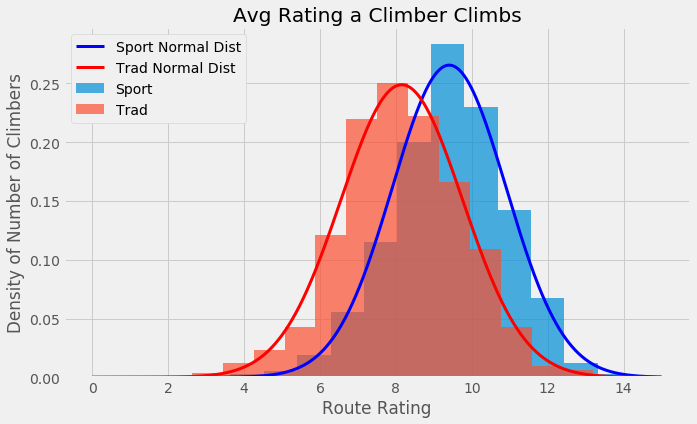

In [116]:
avg_sport = np.mean(climber_stats['sport_avg'])
var_sport = np.var(climber_stats['sport_avg'])
avg_trad = np.mean(climber_stats['trad_avg'])
var_trad = np.var(climber_stats['trad_avg'])
n_sport = len(climber_stats[climber_stats['sport_avg'].notnull()])
n_trad = len(climber_stats[climber_stats['trad_avg'].notnull()])

sport_norm_dist = stats.norm(avg_sport, np.sqrt(var_sport))
trad_norm_dist = stats.norm(avg_trad, np.sqrt(var_trad))
curve_x = np.linspace(0, 15, 10**4)

bins = 15
alpha = .7
lw = 3
fig, ax = plt.subplots(figsize=(10,6))
ax.hist(climber_stats['sport_avg'], bins=bins, alpha=alpha, label='Sport', density=True);
ax.hist(climber_stats['trad_avg'], bins=bins, alpha=alpha, label='Trad', density=True);
ax.plot(curve_x, sport_norm_dist.pdf(curve_x), linewidth=lw, color='b', label='Sport Normal Dist');
ax.plot(curve_x, trad_norm_dist.pdf(curve_x), linewidth=lw, color='r', label='Trad Normal Dist');
ax.set_ylabel('Density of Number of Climbers');
ax.set_xlabel('Route Rating');
ax.set_title('Avg Rating a Climber Climbs');
ax.legend(loc='upper left', framealpha=1);

plt.savefig('./images/avg_rating_norm.png', bbox_inches='tight')

p-value = 0.00


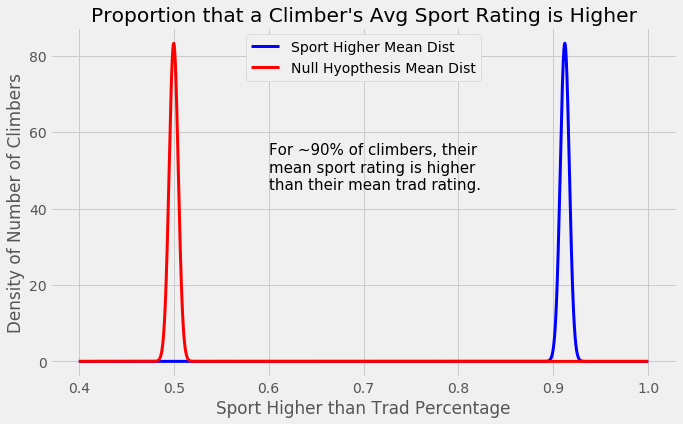

In [141]:
# testing of binomial perspective (sport > trad)
# null hypothesis that they are the same would mean mean is 0.5
# alt is that it is > 0.5

avg_sport_higher = np.mean(climber_stats['avg_sport_higher'])
var_sport_higher = np.var(climber_stats['avg_sport_higher'])
n_sport_higher = len(climber_stats[climber_stats['avg_sport_higher'].notnull()])

sport_higher_norm_dist = stats.norm(avg_sport_higher, np.sqrt(var_sport_higher/n_sport_higher))
null_dist = stats.norm(.5,np.sqrt(var_sport_higher/n_sport_higher))
curve_x = np.linspace(0.4, 1, 10**4)
p_val = 1-null_dist.cdf(avg_sport_higher)

bins = 15
alpha = .7
lw = 3
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(curve_x, sport_higher_norm_dist.pdf(curve_x), linewidth=lw, color='b', label='Sport Higher Mean Dist');
ax.plot(curve_x, null_dist.pdf(curve_x),
        linewidth=lw, color='r', label='Null Hyopthesis Mean Dist');
# ax.axvline(avg_sport_higher, color='blue', linestyle='--', alpha=0.5)
# ax.text(1.4, 1.1, f'p-value of {p_val:2.2f}', fontsize = 15);
# ax.fill_between(np.linspace(avg_sport_higher,1),
#                 null_dist.pdf(np.linspace(avg_sport_higher,2)),
#                 color='red', alpha=0.3)
ax.set_ylabel('Density of Number of Climbers');
ax.set_xlabel('Sport Higher than Trad Percentage');
ax.set_title("Proportion that a Climber's Avg Sport Rating is Higher");
ax.legend(loc='upper center', framealpha=1);
ax.text(.6,45,'For ~90% of climbers, their\nmean sport rating is higher \nthan their mean trad rating.', fontsize = 15)

print(f'p-value = {p_val:2.2f}')

plt.savefig('./images/avg_rating_norm_higher.png', bbox_inches='tight')

In [149]:
# welch's t-test and mann-whitney u-test

res = stats.ttest_ind(climber_stats[climber_stats['sport_avg'].notnull()]['sport_avg'],
                      climber_stats[climber_stats['trad_avg'].notnull()]['trad_avg'],
                      equal_var=False)
print(f"t-test p-value for avg sport > trad: {res.pvalue:2.3f}")

res = stats.mannwhitneyu(climber_stats['sport_avg'], climber_stats['trad_avg'], alternative="greater")
print(f"u-test p-value for avg sport > trad: {res.pvalue:2.3f}")

res = stats.ttest_ind(climber_stats[climber_stats['sport_max'].notnull()]['sport_max'],
                      climber_stats[climber_stats['trad_max'].notnull()]['trad_max'],
                      equal_var=False)
print(f"t-test p-value for max sport > trad: {res.pvalue:2.3f}")

res = stats.mannwhitneyu(climber_stats['sport_max'], climber_stats['trad_max'], alternative="greater")
print(f"u-test p-value for max sport > trad: {res.pvalue:2.3f}")

t-test p-value for avg sport > trad: 0.000
u-test p-value for avg sport > trad: 0.000
t-test p-value for max sport > trad: 0.000
u-test p-value for max sport > trad: 0.000


p-value = 0.00


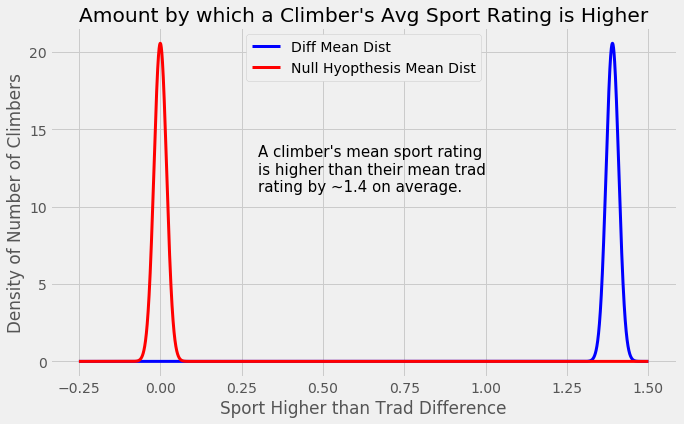

In [161]:
# testing of difference perspective (sport - trad)
# null hypothesis that they are the same would mean mean is 0
# alt is that it is > 0

avg_diff = np.mean(climber_stats['avg_sport_trad_diff'])
var_diff = np.var(climber_stats['avg_sport_trad_diff'])
n_diff = len(climber_stats[climber_stats['avg_sport_trad_diff'].notnull()])

diff_norm_dist = stats.norm(avg_diff, np.sqrt(var_diff/n_diff))
null_dist = stats.norm(0,np.sqrt(var_diff/n_diff))
curve_x = np.linspace(-.25, 1.5, 10**4)
p_val = 1-null_dist.cdf(avg_sport_higher)

bins = 15
alpha = .7
lw = 3
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(curve_x, diff_norm_dist.pdf(curve_x), linewidth=lw, color='b', label='Diff Mean Dist');
ax.plot(curve_x, null_dist.pdf(curve_x),
        linewidth=lw, color='r', label='Null Hyopthesis Mean Dist');
# ax.axvline(avg_diff, color='blue', linestyle='--', alpha=0.5)
# ax.text(-5, .2, f'p-value of {p_val:2.2f}', fontsize = 15)
# ax.fill_between(np.linspace(avg_diff,5),
#                 null_dist.pdf(np.linspace(avg_diff,5)),
#                 color='red', alpha=0.3)
ax.set_ylabel('Density of Number of Climbers');
ax.set_xlabel('Sport Higher than Trad Difference');
ax.set_title("Amount by which a Climber's Avg Sport Rating is Higher");
ax.legend(loc='upper center', framealpha=1);
ax.text(.3,11,"A climber's mean sport rating \nis higher than their mean trad \nrating by ~1.4 on average.", fontsize = 15)

print(f'p-value = {p_val:2.2f}')

plt.savefig('./images/avg_rating_norm_diff.png', bbox_inches='tight')

In [111]:
def sample_size_needed_for_power(alpha, power, mu0, mua, sigma):
    standard_normal = stats.norm(0, 1)
    beta = 1 - power
    numerator = sigma * (standard_normal.ppf(1 - alpha) - standard_normal.ppf(beta))
    denominator = mua - mu0
    return (numerator / denominator) ** 2

sample_size_needed_for_power(.05, .95, 0, 1.25, np.sqrt(var_diff))

9.096201563508869

In [114]:
def compute_power(n, sigma, alpha, mu0, mua):
    standard_error = sigma / n**0.5
    h0 = stats.norm(mu0, standard_error)
    ha = stats.norm(mua, standard_error)
    critical_value = h0.ppf(1 - alpha)
    power = 1 - ha.cdf(critical_value)
    return power

compute_power(n_diff, np.sqrt(var_diff), .05, 0, avg_diff)

1.0

p-value = 0.00


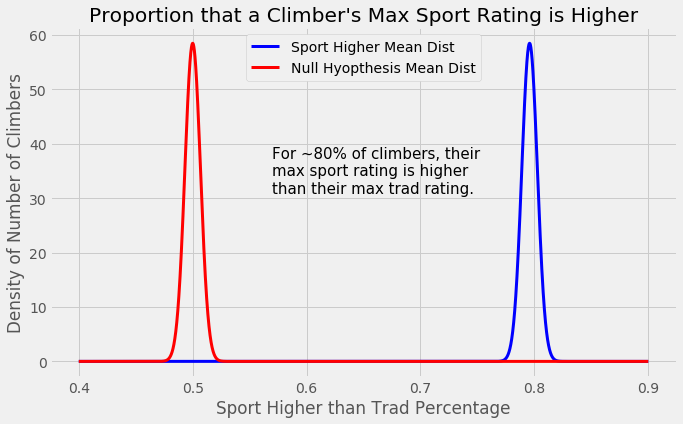

In [145]:
## COMPUTED FOR MAX
# testing of binomial perspective (sport > trad)
# null hypothesis that they are the same would mean mean is 0.5
# alt is that it is > 0.5

avg_sport_higher = np.mean(climber_stats['max_sport_higher'])
var_sport_higher = np.var(climber_stats['max_sport_higher'])
n_sport_higher = len(climber_stats[climber_stats['max_sport_higher'].notnull()])

sport_higher_norm_dist = stats.norm(avg_sport_higher, np.sqrt(var_sport_higher/n_sport_higher))
null_dist = stats.norm(.5,np.sqrt(var_sport_higher/n_sport_higher))
curve_x = np.linspace(0.4, .9, 10**4)
p_val = 1-null_dist.cdf(avg_sport_higher)

bins = 15
alpha = .7
lw = 3
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(curve_x, sport_higher_norm_dist.pdf(curve_x), linewidth=lw, color='b', label='Sport Higher Mean Dist');
ax.plot(curve_x, null_dist.pdf(curve_x),
        linewidth=lw, color='r', label='Null Hyopthesis Mean Dist');
# ax.axvline(avg_sport_higher, color='blue', linestyle='--', alpha=0.5)
# ax.text(1.4, 1.1, f'p-value of {p_val:2.2f}', fontsize = 15);
# ax.fill_between(np.linspace(avg_sport_higher,1),
#                 null_dist.pdf(np.linspace(avg_sport_higher,2)),
#                 color='red', alpha=0.3)
ax.set_ylabel('Density of Number of Climbers');
ax.set_xlabel('Sport Higher than Trad Percentage');
ax.set_title("Proportion that a Climber's Max Sport Rating is Higher");
ax.legend(loc='upper center', framealpha=1);
ax.text(.57,31,'For ~80% of climbers, their\nmax sport rating is higher \nthan their max trad rating.', fontsize = 15)

print(f'p-value = {p_val:2.2f}')

plt.savefig('./images/max_rating_norm_higher.png', bbox_inches='tight')

p-value = 0.00


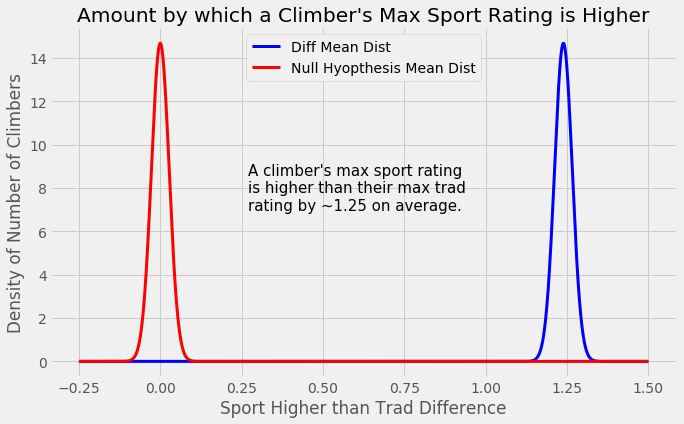

In [159]:
## COMPUTED USING MAX
# testing of difference perspective (sport - trad)
# null hypothesis that they are the same would mean mean is 0
# alt is that it is > 0

avg_diff = np.mean(climber_stats['max_sport_trad_diff'])
var_diff = np.var(climber_stats['max_sport_trad_diff'])
n_diff = len(climber_stats[climber_stats['max_sport_trad_diff'].notnull()])

diff_norm_dist = stats.norm(avg_diff, np.sqrt(var_diff/n_diff))
null_dist = stats.norm(0,np.sqrt(var_diff/n_diff))
curve_x = np.linspace(-.25, 1.5, 10**4)
p_val = 1-null_dist.cdf(avg_sport_higher)

bins = 15
alpha = .7
lw = 3
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(curve_x, diff_norm_dist.pdf(curve_x), linewidth=lw, color='b', label='Diff Mean Dist');
ax.plot(curve_x, null_dist.pdf(curve_x),
        linewidth=lw, color='r', label='Null Hyopthesis Mean Dist');
# ax.axvline(avg_diff, color='blue', linestyle='--', alpha=0.5)
# ax.text(-5, .2, f'p-value of {p_val:2.2f}', fontsize = 15)
# ax.fill_between(np.linspace(avg_diff,5),
#                 null_dist.pdf(np.linspace(avg_diff,5)),
#                 color='red', alpha=0.3)
ax.set_ylabel('Density of Number of Climbers');
ax.set_xlabel('Sport Higher than Trad Difference');
ax.set_title("Amount by which a Climber's Max Sport Rating is Higher");
ax.legend(loc='upper center', framealpha=1);
ax.text(.27,7,"A climber's max sport rating \nis higher than their max trad \nrating by ~1.25 on average.", fontsize = 15)

print(f'p-value = {p_val:2.2f}')

plt.savefig('./images/max_rating_norm_diff.png', bbox_inches='tight')